In [36]:
# ] activate .

In [37]:
# using Pkg
# Pkg.resolve()

# Imports

In [12]:
import JSON
import Base64
import Luxor
import Serialization

using Gen, Distributions
import Gen  # to be able to do Gen.xxx for autocompletion and documentation
import Plots


In [13]:
include("./src/inverse-planning/geometric_primitives.jl");
include("./src/inverse-planning/scene.jl");
include("./src/inverse-planning/viz.jl");
include("./src/inverse-planning/planning.jl");



include("./src/read_data.jl")
include("./src/utils.jl")
include("./src/agents/simple_agent_1.jl")

# Alias
# import Main.utils: utils # utils no longer module so cant do this
# import Main.read_data: read_data



DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##simpleagent1_model#293", Bool[0], false)

# Load data

In [3]:

roomnum = "83"
file_name = "memory_2.1.14.json"
data_number = 1

room = readdata_get_comm_game_path() * "/python_scripts/visualize/pairs_data/room0000"*roomnum
dict1 = readdata_get_task_from_room(room, file_name);
playerdata = readdata_get_playerdata_from_task(dict1, data_number);
# for i in 1:length(dict1)
#     playerdata = read_data.get_playerdata_from_task(dict1, i);
# end
length(dict1)
# dict1

pair: 61-62
Getting file:memory_2.1.14.json
Json length:20 | #Runs should be (n-2)/2 = 9.0
Mode(TEACH/TEST): TEACH
role(TEACHER/STUDENT): TEACHER


20

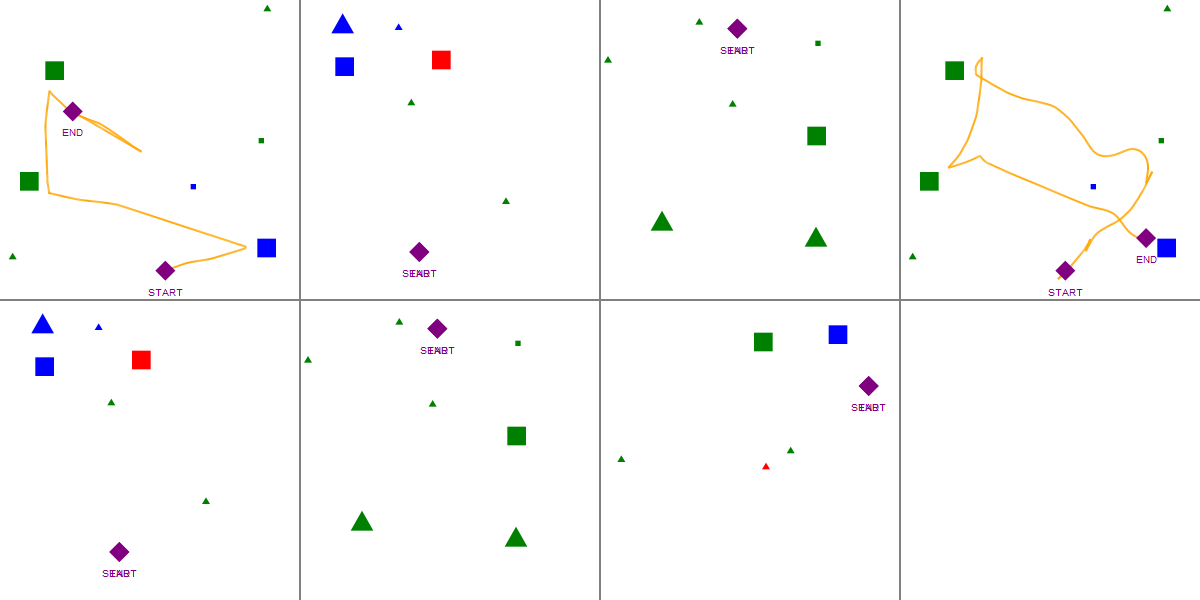

In [82]:
# choose a room number (1,2,...,13) and task number (1,2,...,44) to visualize the complete task
# readdata_all_rooms[6]
# tasknum = 1
# tasknum += 1
readdata_visualize_memory(roomnum=readdata_all_rooms[11], tasknum=5; hide_student=true, VERBOSE=false)


In [3]:
roomnum = "83"
file_name = "memory_2.1.1.json"
room = readdata_get_comm_game_path() * "/python_scripts/visualize/pairs_data/room0000"*roomnum
dict1 = readdata_get_task_from_room(room, file_name, VERBOSE=false);
playerdata1 = readdata_get_playerdata_from_task(dict1, 1, VERBOSE=false);
scene = utils_scene_from_playerdata(playerdata1, VERBOSE=false)

start = Point(1, 1)
dest = Point(210, 440)
planner_params = PlannerParams(rrt_iters=600, rrt_dt=3.0,
                               refine_iters=3500, refine_std=1.)
example_path = plan_path(start, dest, scene, planner_params)

println(length(example_path.points))
# visualize() do
#     draw_trace(Dict(:start => start,
#                     :dest => dest,
#                     :scene => scene,
#                     :path => example_path.points);
#                should_draw_measurements=false)
# end


2


Point[Point(1.0, 1.0), Point(1.042985374313683, 1.0902898532234775), Point(1.0859707486273413, 1.1805797064469037), Point(1.1289561229410243, 1.2708695596703812), Point(1.1719414972546829, 1.3611594128938076), Point(1.2149268715683659, 1.451449266117285), Point(1.2579122458820486, 1.5417391193407626), Point(1.3008976201957072, 1.6320289725641888), Point(1.3438829945093902, 1.7223188257876663), Point(1.3868683688230485, 1.8126086790110925)]


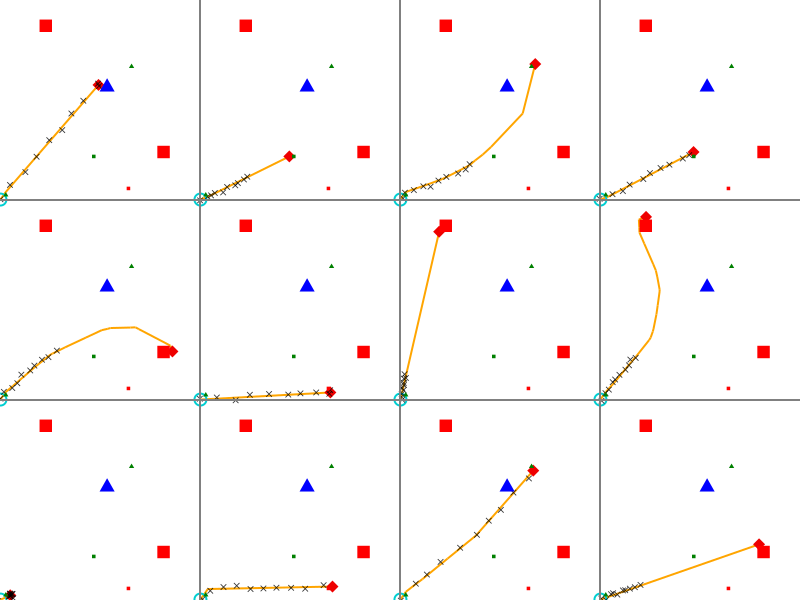

In [16]:
speed = 1.
dt = 0.1
num_ticks = 10;
example_locations = walk_path(example_path, speed, dt, num_ticks)
println(example_locations)


constraints = Gen.choicemap()
constraints[:start_x] = 1
constraints[:start_y] = 1
# constraints[:dest_x] = 210
# constraints[:dest_y] = 440
# constraints[:meas => (1, :x)] = 100
# constraints[:meas => (1, :y)] = 100

planner_params = PlannerParams(rrt_iters=600, rrt_dt=30.0,
                               refine_iters=3500, refine_std=5.)

aargs = simpleagent1_make_args(scene, dt, num_ticks, planner_params)
traces = [Gen.generate(
    simpleagent1_model, (aargs, ), constraints
    )[1] for i in 1:12];
visualize_grid(traces, 4, 800; separators="gray") do trace, frame
    draw_trace(trace, frame; draw_measurements=true, markersize=6)
end


# DO INFERENCE

scene size: 450 450
TAKING TEACHER:
50
Done trees.


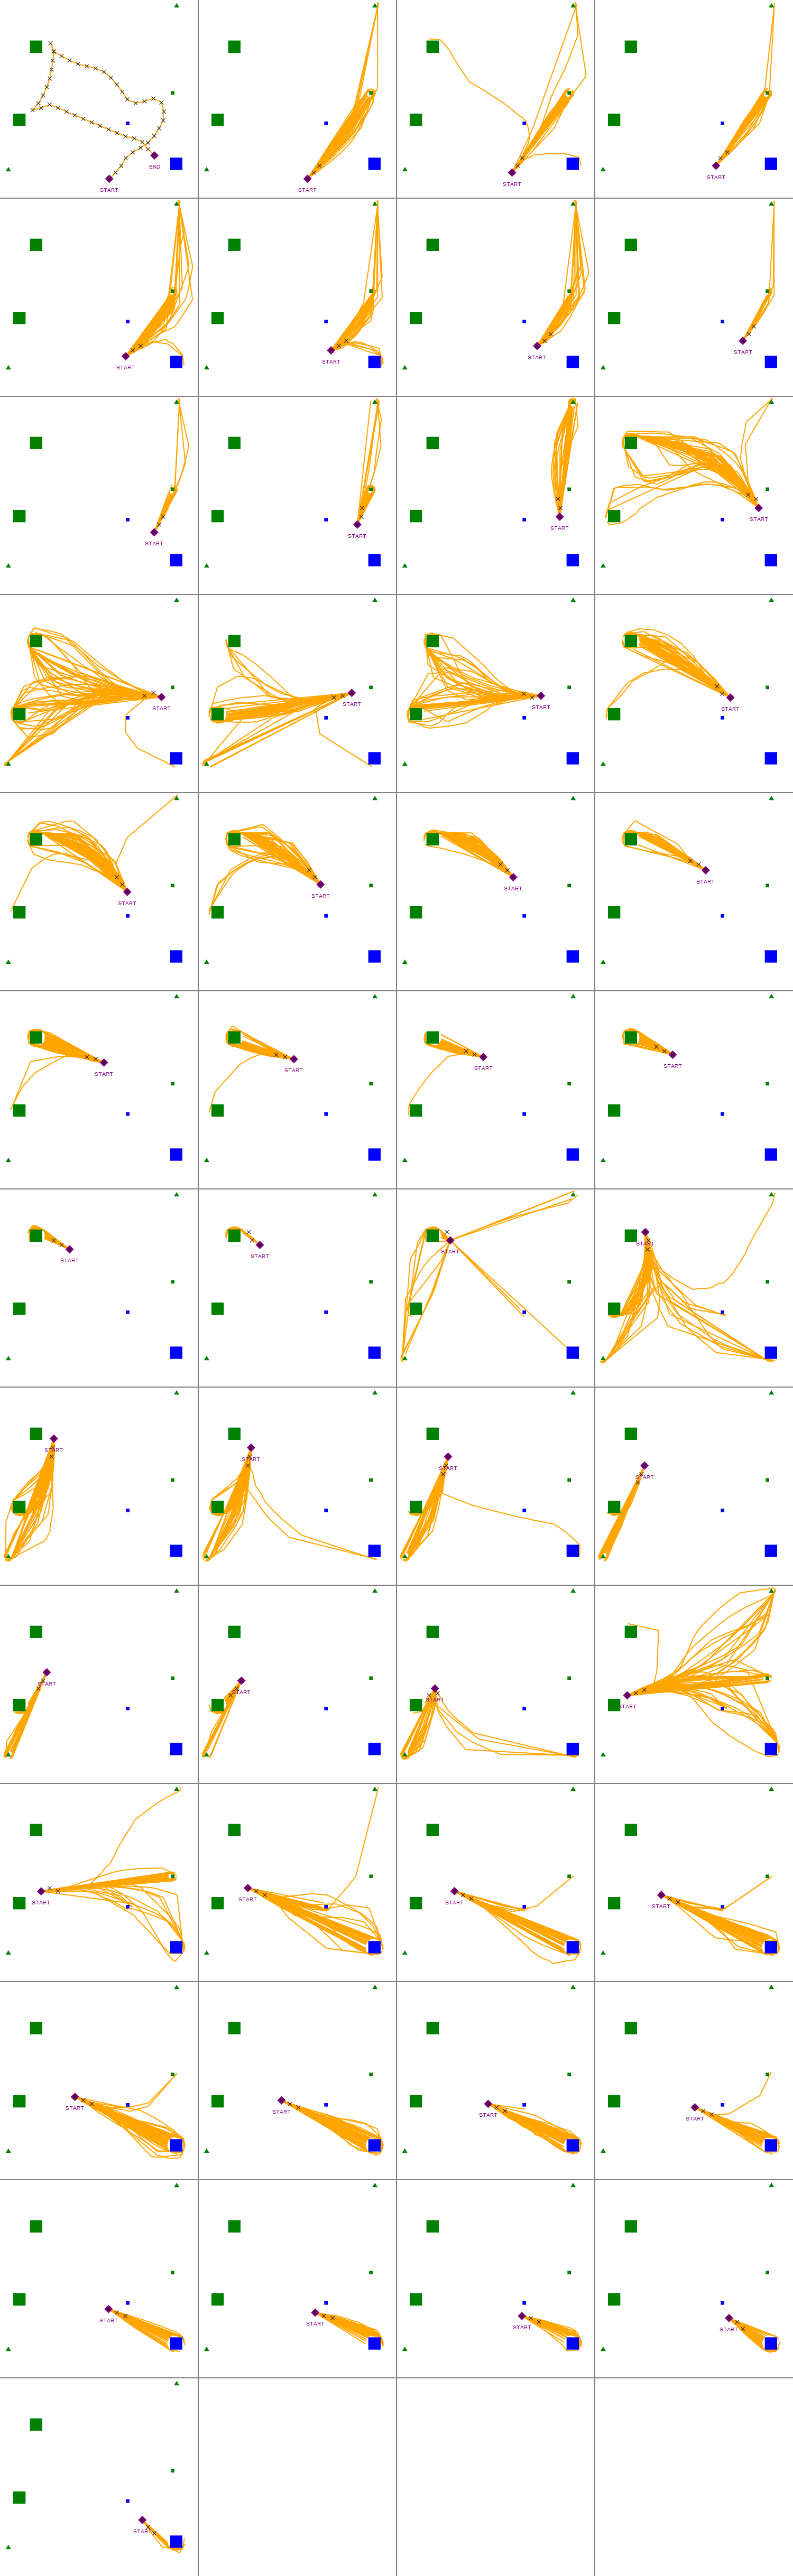

In [14]:
function block_resimulation_update(trace)
    (trace,b3) = mh(trace, select(:obstacle_outlier, :dest_shape, :dest_angle, :speed))

    for i=1:10
        (trace,b1) = mh(trace, select(:dest_angle))
        (trace,b2) = mh(trace, select(:speed)) 
    end

    return trace
end
function do_inference_mh(agent_args::Dict, start::Point, measurements::Vector{Point}, amount_of_computation::Int)
    observations = Gen.choicemap()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end
    (trace, _) = Gen.generate(simpleagent1_model, (agent_args,), observations)
    for iter=1:amount_of_computation
        trace = block_resimulation_update(trace)
    end
    return trace
end
function do_inference(agent_args::Dict, start::Point, measurements::Vector{Point}, amount_of_computation::Int)
    observations = Gen.choicemap()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end
    (trace, _) = importance_resampling(simpleagent1_model, (agent_args, ), observations, amount_of_computation)
    return trace
end;

file_name = "memory_2.1.5.json"
room = readdata_get_comm_game_path() * "/python_scripts/visualize/pairs_data/room0000"*readdata_all_rooms[11]
dict1 = readdata_get_task_from_room(room, file_name, VERBOSE=false);
i = 4
playerdata1 = readdata_get_playerdata_from_task(dict1, 2*i - 1, VERBOSE=false);
playerdata2 = readdata_get_playerdata_from_task(dict1, 2*i, VERBOSE=false);
scene = utils_scene_from_playerdata(playerdata1)

if playerdata1["role"] == "STUDENT"  # Make player1 always teacher
    playerdata1, playerdata2 = playerdata2, playerdata1
end
player_trajectory1 = [Point(x, y) for (x, y) in zip(playerdata1["x"], playerdata1["y"])]
player_trajectory2 = [Point(x, y) for (x, y) in zip(playerdata2["x"], playerdata2["y"])]
player_trajectory1 = utils_strip_trajectory(player_trajectory1; epsilon=20)
player_trajectory2 = utils_strip_trajectory(player_trajectory2; epsilon=20)

if length(player_trajectory1) > length(player_trajectory2)
    println("TAKING TEACHER:")
    trajectory = player_trajectory1
else
    println("TAKING STUDENT:")
    trajectory = player_trajectory2
end
println(length(trajectory))

# measuremene = [utils_obstacle_touch_point(v, uniform(0, 2*pi)) for v in scene.obstacles]  # measurements as destination to shapes

num_ticks = 3;
dt = 1/(num_ticks-1)
planner_params = PlannerParams(rrt_iters=500, rrt_dt=25,
                               refine_iters=1000, refine_std=5.)
pre_comp_rrt_vector = [[generate_rrt(scene, start, planner_params.rrt_iters, planner_params.rrt_dt) for _ in 1:50] for start in trajectory]
println("Done trees.")
flush(stdout)
computation_amt=400
samples = 80;

posterior_shapes = []
posterior_speeds = []
all_traces = Dict()
# visualize_inference(measuremene, aargs, measuremene[1], computation_amt=50, samples=100)
visualize_grid(0:length(trajectory)-(num_ticks-1), 4, 1500; separators="gray") do i, frame
# visualize_grid(0:1, 5, 1500; separators="gray") do i, frame
    if i == 0
        draw_path(scene, trajectory[1], trajectory[end], trajectory, frame; markersize=8, pathopacity=1)
        draw_measurements(scene, trajectory, frame; markersize=8)
        draw_scene(scene, frame)
    else
        push!(posterior_shapes, [0 for _ in range(1, length(scene.obstacles))])
        measuremene = trajectory[i:i+num_ticks-1]
        # println(measuremene)
        agent_args = simpleagent1_make_args(scene, dt, num_ticks, planner_params; pre_comp_rrt=pre_comp_rrt_vector[i], obstacle_outlier=0.1)
        # agent_args = simpleagent1_make_args(scene, dt, num_ticks, planner_params)
        for j in 1:samples
            trace = do_inference(agent_args, measuremene[1], measuremene, computation_amt)
            # trace = do_inference_mh(agent_args, measuremene[1], measuremene, Integer(computation_amt/20))
            # println(get_score(trace))
            push!(posterior_speeds, trace[:speed])
            planning_failed = Gen.get_retval(trace)[:planning_failed]
            if trace[:obstacle_outlier]
                continue
            end
            posterior_shapes[i][trace[:dest_shape]] += 1
            # println(trace[:tree_choice])
            trace = trace_to_dict(trace)
            if planning_failed
                continue
            end
            draw_path(trace[:scene], trace[:start], trace[:dest], trace[:path], frame; markersize=8, pathopacity=1, startopacity=0, destopacity=0)

        end
        draw_path(scene, measuremene[1], measuremene[1], [], frame; markersize=8, pathopacity=1, startopacity=1, destopacity=0)
        draw_measurements(scene, measuremene, frame; markersize=8)
        draw_scene(scene, frame)
    end
end
# posterior_shapes

In [10]:
visualize_grid(0:length(trajectory)-(num_ticks-1), 4, 150; separators="gray") do i, frame
    # visualize_grid(0:1, 5, 1500; separators="gray") do i, frame
    if i == 0
        draw_path(scene, trajectory[1], trajectory[end], trajectory, frame; markersize=8, pathopacity=1)
        draw_measurements(scene, trajectory, frame; markersize=8)
        draw_scene(scene, frame)
    else
        measuremene = trajectory[i:i+num_ticks-1]
        for j in 1:samples
            if !(string(i)*"_"*string(j) in keys(all_traces))
                continue
            end
            trace = all_traces[string(i)*"_"*string(j)]
            draw_path(trace[:scene], trace[:start], trace[:dest], trace[:path], frame; markersize=8, pathopacity=1, startopacity=0, destopacity=0)
        end
        draw_path(scene, measuremene[1], measuremene[1], [], frame; markersize=8, pathopacity=1, startopacity=1, destopacity=0)
        draw_measurements(scene, measuremene, frame; markersize=8)
        draw_scene(scene, frame)
    end
end

LoadError: UndefVarError: trajectory not defined

In [11]:
xtop = 50
ytop = 125
vlines = [0, 9, 14.5, 26.5, 37, 48]

Plots.plot(size=(1300,400))
Plots.xlims!(0, xtop)
Plots.ylims!(0, ytop)

for i in 1:2:length(vlines)
    Plots.plot!(Plots.Shape([(vlines[i],0),(vlines[i],ytop),(vlines[i+1],ytop),(vlines[i+1],0)]), color=:blue, alpha=0.1, label=nothing)
end

Plots.plot!(permutedims(hcat(posterior_shapes...)), labels=utils_get_obs_labels(scene),legend=:topleft)

Plots.vline!(vlines, linestyle=:dash, linecolor=:black, linewidth=1, label=nothing)

counter = 0
for i in 1:2:length(vlines)
    mp = (vlines[i]+vlines[i+1])/2
    c = 'A' + counter
    Plots.annotate!([(mp, 20, ("("*c*")", 20, 0.0, :bottom, :black))])
    counter = counter+1
end
Plots.title!("Posterior on target shapes")
Plots.xlabel!("Trace")
Plots.savefig("output.svg")
Plots.current()
# Matrix{Float64}(posterior_shapes)
# labels

LoadError: UndefVarError: posterior_shapes not defined

In [200]:
using PlotlyJS

trace1 = box(y=posterior_speeds, boxpoints="all", quartilemethod="linear", name="speed")
plot([trace1])


data: [
  "box with fields boxpoints, name, quartilemethod, type, and y"
]

layout: "layout with fields margin and template"

In [82]:
trace1 = box(y=posterior_speeds, boxpoints="all", quartilemethod="linear", name="speed")
plot([trace1])


data: [
  "box with fields boxpoints, name, quartilemethod, type, and y"
]

layout: "layout with fields margin and template"

# TEMP SAVE DATA IN FILE

In [16]:
import Serialization


function get_all_traces(roomnum, tasknum, runno)
    x = tasknum <= 40 ? "2" : "4"
    y = string((tasknum-1) % 40 + 1)
    file_name = "memory_"*x*".1."*y*".json"
    room = readdata_get_comm_game_path() * "/python_scripts/visualize/pairs_data/room0000"*roomnum
    dict1 = readdata_get_task_from_room(room, file_name, VERBOSE=false);
    playerdata1 = readdata_get_playerdata_from_task(dict1, 2*runno - 1, VERBOSE=false);
    playerdata2 = readdata_get_playerdata_from_task(dict1, 2*runno, VERBOSE=false);
    scene = utils_scene_from_playerdata(playerdata1, VERBOSE=false)
    
    player_trajectory1 = [Point(x, y) for (x, y) in zip(playerdata1["x"], playerdata1["y"])]
    player_trajectory2 = [Point(x, y) for (x, y) in zip(playerdata2["x"], playerdata2["y"])]
    
    player_trajectory1 = utils_strip_trajectory(player_trajectory1; epsilon=20)
    player_trajectory2 = utils_strip_trajectory(player_trajectory2; epsilon=20)
    if length(player_trajectory1) > length(player_trajectory2)
        trajectory = player_trajectory1
    else
        trajectory = player_trajectory2
    end

    num_ticks = 3;
    dt = 1/(num_ticks-1)
    planner_params = PlannerParams(rrt_iters=200, rrt_dt=10,
                                refine_iters=1000, refine_std=5.)
    agent_args = simpleagent1_make_args(scene, dt, num_ticks, planner_params)

    computation_amt=60
    samples = 100;

    all_traces = []
    for i in 1:length(trajectory)-(num_ticks-1)
        push!(all_traces, [])
        measuremene = trajectory[i:i+num_ticks-1]
        for j in 1:samples
            trace = do_inference(agent_args, measuremene[1], measuremene, computation_amt)
            push!(all_traces[i], trace)
        end
    end
    return all_traces
end

function get_all_traces_room_task(roomnum, tasknum)
    x = tasknum <= 40 ? "2" : "4"
    y = string((tasknum-1) % 40 + 1)
    file_name = "memory_"*x*".1."*y*".json"
    room = readdata_get_comm_game_path() * "/python_scripts/visualize/pairs_data/room0000"*roomnum
    dict1 = readdata_get_task_from_room(room, file_name, VERBOSE=false);
    # runcount = Integer(floor((length(dict1)-2)/2))
    runcount = 1 # ONLY DO TEACHER #1
    roomtask_traces = Dict()
    for runnum in 1:runcount
        try
            run_result = get_all_traces(roomnum, tasknum, runnum)
            roomtask_traces[runnum] = run_result
        catch e
            println("\nRoom Task runcount Error: ", (roomnum, tasknum, runnum, e), "\n   ")
        end
    end
    return roomtask_traces
end

for roomnum in readdata_all_rooms[1:1]
    println("\n", roomnum, ": ")
    for tasknum in 1:1
        print(tasknum, " ")
        flush(stdout)
        try
            roomtask_traces = get_all_traces_room_task(roomnum, tasknum)
            Serialization.serialize("data/"*roomnum*"_"*string(tasknum)*".data", roomtask_traces)
        catch e
            println("Room Task Error ", (roomnum, tasknum, e))
        end
    end
end



58: 
1 

In [17]:
import Serialization

# Serialization.serialize("data/file.dat", all_traces)
function viz_room_task(roomnum, tasknum)
    x = tasknum <= 40 ? "2" : "4"
    y = string((tasknum-1) % 40 + 1)
    file_name = "memory_"*x*".1."*y*".json"
    room = readdata_get_comm_game_path() * "/python_scripts/visualize/pairs_data/room0000"*roomnum
    dict1 = readdata_get_task_from_room(room, file_name, VERBOSE=false);
    runno = 1  # only did run 1

    # load player data to vizualize in first picture
    playerdata1 = readdata_get_playerdata_from_task(dict1, 2*runno - 1, VERBOSE=false);
    playerdata2 = readdata_get_playerdata_from_task(dict1, 2*runno, VERBOSE=false);
    scene = utils_scene_from_playerdata(playerdata1, VERBOSE=false)
    
    player_trajectory1 = [Point(x, y) for (x, y) in zip(playerdata1["x"], playerdata1["y"])]
    player_trajectory2 = [Point(x, y) for (x, y) in zip(playerdata2["x"], playerdata2["y"])]
    
    player_trajectory1 = utils_strip_trajectory(player_trajectory1; epsilon=20)
    player_trajectory2 = utils_strip_trajectory(player_trajectory2; epsilon=20)
    if length(player_trajectory1) > length(player_trajectory2)
        trajectory = player_trajectory1
    else
        trajectory = player_trajectory2
    end

    # load data file to vizualize
    data_file = Serialization.deserialize("data/"*roomnum*"_"*string(tasknum)*".data")
    run_traces = data_file[runno]
    posterior_shapes = []

    visualize_grid(0:length(run_traces), 5, 1500; separators="gray") do i, frame
        if i == 0
            draw_path(scene, trajectory[1], trajectory[end], trajectory, frame; markersize=8, pathopacity=1)
            draw_measurements(scene, trajectory, frame; markersize=8)
            draw_scene(scene, frame)
        else
            # println("runtraces ", length(run_traces), " ", length(run_traces[1]))
            push!(posterior_shapes, [0 for _ in range(1, length(scene.obstacles))])
            # measuremene = trajectory[i:i+num_ticks-1]
            # println(measuremene)
            for j in 1:length(run_traces[i])
                trace = run_traces[i][j]
                planning_failed = Gen.get_retval(trace)[:planning_failed]
                posterior_shapes[i][trace[:dest_shape]] += 1
                trace = trace_to_dict(trace)
                if planning_failed
                    # draw_trace(trace, frame; should_draw_measurements=true, should_draw_path=false)
                    draw_measurements(trace[:scene], trace[:measurements], frame; markersize=8)
                    continue
                end
                draw_path(trace[:scene], trace[:start], trace[:dest], trace[:path], frame; markersize=8, pathopacity=1)
                draw_measurements(trace[:scene], trace[:measurements], frame; markersize=8)
            end
            draw_scene(scene, frame)
        end
    end
    return posterior_shapes
end

posterior_shapes = viz_room_task(readdata_all_rooms[1], 1)
posterior_shapes

49-element Vector{Any}:
 [1, 46, 0, 0, 9, 0, 18, 26]
 [3, 49, 0, 0, 16, 0, 3, 29]
 [1, 50, 0, 0, 24, 0, 1, 24]
 [1, 59, 0, 0, 15, 0, 3, 22]
 [0, 50, 0, 0, 11, 0, 3, 36]
 [1, 54, 0, 0, 7, 0, 4, 34]
 [1, 61, 1, 0, 4, 0, 2, 31]
 [1, 54, 1, 0, 6, 0, 0, 38]
 [0, 47, 1, 0, 12, 0, 0, 40]
 [0, 61, 0, 0, 6, 0, 0, 33]
 [0, 65, 1, 0, 4, 0, 0, 30]
 [0, 61, 0, 0, 6, 0, 0, 33]
 [0, 59, 0, 0, 1, 0, 0, 40]
 ⋮
 [0, 31, 0, 0, 2, 0, 12, 55]
 [36, 0, 0, 21, 0, 43, 0, 0]
 [40, 0, 0, 26, 0, 34, 0, 0]
 [30, 0, 1, 28, 0, 41, 0, 0]
 [49, 0, 1, 18, 0, 32, 0, 0]
 [70, 0, 3, 7, 0, 19, 0, 1]
 [84, 0, 11, 0, 0, 3, 1, 1]
 [44, 0, 56, 0, 0, 0, 0, 0]
 [28, 0, 70, 0, 2, 0, 0, 0]
 [4, 0, 81, 0, 3, 0, 0, 12]
 [0, 0, 84, 0, 3, 0, 0, 13]
 [0, 0, 96, 0, 1, 0, 0, 3]

# TEMP LABEL DATA

In [4]:
import Serialization
labels_loaded = Serialization.deserialize("data/0_labels_8") # LOAD!

for k in keys(labels_loaded)
    if length(labels_loaded[k]) == 0
        continue
    end
    display(k)
    display(labels_loaded[k])
end


println("Positive:")
pos_count = 0
for rk in keys(labels_loaded)
    count = length([1 for l in keys(labels_loaded[rk]) if length(labels_loaded[rk][l])>0])
    count>0 && print(rk, ":", count, " - ")
    pos_count += count
end
println("\nTotal: ", pos_count)
println("\nNegative:")
neg_count = 0
for rk in keys(labels_loaded)
    count = length([1 for l in keys(labels_loaded[rk]) if length(labels_loaded[rk][l])==0])
    count>0 && print(rk, ":", count, " - ")
    neg_count += count
end
println("\nTotal: ", neg_count)


"81"

Dict{Any, Any} with 14 entries:
  "12_1"  => Any[]
  "31_11" => Any[]
  "2_7"   => Any[]
  "13_1"  => Any[]
  "2_5"   => Any[]
  "25_6"  => [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 3…
  "9_1"   => Any[]
  "1_1"   => Any[]
  "7_1"   => Any[]
  "10_1"  => Any[]
  "1_3"   => Any[]
  "2_1"   => Any[]
  "11_1"  => Any[]
  "8_1"   => Any[]

"79"

Dict{Any, Any} with 5 entries:
  "33_1" => [8, 9, 10, 11, 12, 13, 14, 15, 16, 17  …  23, 24, 25, 26, 27, 28, 2…
  "13_1" => [25, 26, 27, 28, 29, 30, 31, 32, 33, 34  …  118, 119, 120, 121, 122…
  "22_3" => [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
  "36_1" => [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
  "8_1"  => [15, 16, 17, 18, 19, 20, 21, 22, 23, 24  …  67, 68, 69, 70, 71, 72,…

"58"

Dict{Any, Any} with 5 entries:
  "1_1" => Any[]
  "3_1" => Any[]
  "5_1" => Any[]
  "4_1" => Any[]
  "2_1" => [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]

"83"

Dict{Any, Any} with 31 entries:
  "14_6"  => [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
  "31_1"  => [20, 21, 22, 23, 24, 25, 26, 27, 28, 29  …  53, 54, 55, 56, 57, 58…
  "31_11" => [19, 20, 21, 22, 23, 24, 25, 26, 27, 28  …  30, 31, 32, 33, 34, 35…
  "8_1"   => [65, 66, 67, 68, 69, 70, 71, 72, 73, 74  …  79, 80, 81, 82, 83, 84…
  "18_1"  => Any[]
  "28_1"  => [13, 14, 15, 16, 17, 18, 19, 20, 21, 22  …  28, 29, 30, 31, 32, 33…
  "27_4"  => [21, 22, 23, 24, 25, 26, 27, 28, 29, 30  …  32, 33, 34, 35, 36, 37…
  "26_1"  => [29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4…
  "28_3"  => [18, 19, 20, 21, 22, 23, 24, 25, 26, 27  …  30, 31, 32, 33, 34, 35…
  "32_3"  => [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3…
  "30_1"  => [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  "16_9"  => [27, 28, 29, 30, 31, 32, 33, 34, 35, 36  …  45, 46, 47, 48, 49, 50…
  "31_4"  => [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
  "1_1"   

"76"

Dict{Any, Any} with 33 entries:
  "16_1"  => [15, 16, 17, 18, 19, 20, 21, 22, 23, 24  …  27, 28, 29, 30, 31, 32…
  "19_5"  => Any[]
  "11_2"  => [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2…
  "13_1"  => Any[]
  "15_7"  => Any[]
  "24_1"  => Any[]
  "11_10" => [12, 13, 14, 15, 16, 17, 18, 19, 20, 21  …  33, 34, 35, 36, 37, 38…
  "26_1"  => Any[]
  "28_1"  => Any[]
  "26_10" => [24, 25, 26, 27, 28, 29, 30, 31, 32, 33  …  35, 36, 37, 38, 39, 40…
  "28_3"  => Any[]
  "11_5"  => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  23, 24, 25, 26, 27, 28, 29, 30,…
  "11_13" => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  28, 29, 30, 31, 32, 33, 34, 35,…
  "19_1"  => Any[]
  "14_1"  => Any[]
  "12_1"  => [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
  "28_6"  => Any[]
  "17_4"  => Any[]
  "15_4"  => Any[]
  "16_3"  => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  "10_11" => [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,…
  "26_3"  => Any[]
  "11_16" =

"70"

Dict{Any, Any} with 9 entries:
  "8_9"  => [12, 13, 14, 15, 16, 17, 18]
  "9_1"  => [26, 27, 28, 29, 30, 31, 32, 33, 34, 35  …  47, 48, 49, 50, 51, 52,…
  "6_3"  => [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  "12_1" => [10, 11, 12, 13, 14, 15, 16, 17, 18, 19  …  91, 92, 93, 94, 95, 96,…
  "8_14" => [4, 5, 6, 7, 8, 9, 10, 11, 12, 13  …  38, 39, 40, 41, 42, 43, 44, 4…
  "7_3"  => [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
  "13_1" => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  "2_1"  => Any[]
  "6_7"  => [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,…

"69"

Dict{Any, Any} with 7 entries:
  "9_1" => Any[]
  "1_1" => Any[]
  "7_1" => Any[]
  "3_1" => Any[]
  "5_1" => Any[]
  "4_1" => Any[]
  "2_1" => Any[]

Positive:
81:1 - 79:5 - 58:1 - 83:22 - 76:15 - 70:8 - 
Total: 52

Negative:
81:13 - 58:4 - 83:9 - 76:18 - 70:1 - 69:7 - 
Total: 52


In [5]:
labels = labels_loaded # LOAD!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


Dict{String, Dict{Any, Any}} with 13 entries:
  "81" => Dict("12_1"=>Any[], "31_11"=>Any[], "2_7"=>Any[], "13_1"=>Any[], "2_5…
  "72" => Dict()
  "79" => Dict("33_1"=>[8, 9, 10, 11, 12, 13, 14, 15, 16, 17  …  23, 24, 25, 26…
  "58" => Dict("1_1"=>Any[], "3_1"=>Any[], "5_1"=>Any[], "4_1"=>Any[], "2_1"=>[…
  "83" => Dict("14_6"=>[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]…
  "68" => Dict()
  "76" => Dict("16_1"=>[15, 16, 17, 18, 19, 20, 21, 22, 23, 24  …  27, 28, 29, …
  "59" => Dict()
  "61" => Dict()
  "71" => Dict()
  "70" => Dict("8_9"=>[12, 13, 14, 15, 16, 17, 18], "9_1"=>[26, 27, 28, 29, 30,…
  "69" => Dict("9_1"=>Any[], "1_1"=>Any[], "7_1"=>Any[], "3_1"=>Any[], "5_1"=>A…
  "82" => Dict()

In [236]:
Serialization.serialize("data/0_labels_8", labels)  # SAVE!
println("Positive:")
pos_count = 0
for rk in keys(labels)
    count = length([1 for l in keys(labels[rk]) if length(labels[rk][l])>0])
    count>0 && print(rk, ":", count, " - ")
    pos_count += count
end
println("\nTotal: ", pos_count)
println("\nNegative:")
neg_count = 0
for rk in keys(labels)
    count = length([1 for l in keys(labels[rk]) if length(labels[rk][l])==0])
    count>0 && print(rk, ":", count, " - ")
    neg_count += count
end
println("\nTotal: ", neg_count)

for rk in keys(labels)
    if length(labels[rk]) == 0
        # continue
    end
    display(rk)
    display(labels[rk])
end



"81"

Dict{Any, Any} with 14 entries:
  "8_1"   => Any[]
  "31_11" => Any[]
  "2_7"   => Any[]
  "13_1"  => Any[]
  "2_5"   => Any[]
  "25_6"  => [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 3…
  "9_1"   => Any[]
  "1_1"   => Any[]
  "7_1"   => Any[]
  "10_1"  => Any[]
  "1_3"   => Any[]
  "2_1"   => Any[]
  "11_1"  => Any[]
  "12_1"  => Any[]

"72"

Dict{Any, Any}()

"79"

Dict{Any, Any} with 5 entries:
  "33_1" => [8, 9, 10, 11, 12, 13, 14, 15, 16, 17  …  23, 24, 25, 26, 27, 28, 2…
  "13_1" => [25, 26, 27, 28, 29, 30, 31, 32, 33, 34  …  118, 119, 120, 121, 122…
  "22_3" => [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
  "36_1" => [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
  "8_1"  => [15, 16, 17, 18, 19, 20, 21, 22, 23, 24  …  67, 68, 69, 70, 71, 72,…

"58"

Dict{Any, Any} with 5 entries:
  "1_1" => Any[]
  "3_1" => Any[]
  "5_1" => Any[]
  "4_1" => Any[]
  "2_1" => [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]

"83"

Dict{Any, Any} with 31 entries:
  "14_6"  => [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
  "31_1"  => [20, 21, 22, 23, 24, 25, 26, 27, 28, 29  …  53, 54, 55, 56, 57, 58…
  "31_11" => [19, 20, 21, 22, 23, 24, 25, 26, 27, 28  …  30, 31, 32, 33, 34, 35…
  "16_4"  => [20, 21, 22, 23, 24, 25, 26, 27, 28, 29  …  34, 35, 36, 37, 38, 39…
  "18_1"  => Any[]
  "28_1"  => [13, 14, 15, 16, 17, 18, 19, 20, 21, 22  …  28, 29, 30, 31, 32, 33…
  "27_4"  => [21, 22, 23, 24, 25, 26, 27, 28, 29, 30  …  32, 33, 34, 35, 36, 37…
  "26_1"  => [29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4…
  "28_3"  => [18, 19, 20, 21, 22, 23, 24, 25, 26, 27  …  30, 31, 32, 33, 34, 35…
  "32_3"  => [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3…
  "30_1"  => [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  "16_9"  => [27, 28, 29, 30, 31, 32, 33, 34, 35, 36  …  45, 46, 47, 48, 49, 50…
  "31_4"  => [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
  "1_1"   

"68"

Dict{Any, Any}()

"76"

Dict{Any, Any} with 33 entries:
  "16_1"  => [15, 16, 17, 18, 19, 20, 21, 22, 23, 24  …  27, 28, 29, 30, 31, 32…
  "19_5"  => Any[]
  "11_2"  => [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2…
  "13_1"  => Any[]
  "15_7"  => Any[]
  "24_1"  => Any[]
  "11_10" => [12, 13, 14, 15, 16, 17, 18, 19, 20, 21  …  33, 34, 35, 36, 37, 38…
  "26_1"  => Any[]
  "28_1"  => Any[]
  "26_10" => [24, 25, 26, 27, 28, 29, 30, 31, 32, 33  …  35, 36, 37, 38, 39, 40…
  "28_3"  => Any[]
  "11_5"  => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  23, 24, 25, 26, 27, 28, 29, 30,…
  "11_13" => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  28, 29, 30, 31, 32, 33, 34, 35,…
  "19_1"  => Any[]
  "14_1"  => Any[]
  "12_1"  => [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
  "28_6"  => Any[]
  "17_4"  => Any[]
  "15_4"  => Any[]
  "16_3"  => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  "10_11" => [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,…
  "26_3"  => Any[]
  "11_16" =

"59"

Dict{Any, Any}()

"61"

Dict{Any, Any}()

"71"

Dict{Any, Any}()

"70"

Dict{Any, Any} with 9 entries:
  "8_9"  => [12, 13, 14, 15, 16, 17, 18]
  "9_1"  => [26, 27, 28, 29, 30, 31, 32, 33, 34, 35  …  47, 48, 49, 50, 51, 52,…
  "6_7"  => [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,…
  "6_3"  => [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  "8_14" => [4, 5, 6, 7, 8, 9, 10, 11, 12, 13  …  38, 39, 40, 41, 42, 43, 44, 4…
  "7_3"  => [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
  "13_1" => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  "2_1"  => Any[]
  "12_1" => [10, 11, 12, 13, 14, 15, 16, 17, 18, 19  …  91, 92, 93, 94, 95, 96,…

"69"

Dict{Any, Any} with 7 entries:
  "9_1" => Any[]
  "1_1" => Any[]
  "7_1" => Any[]
  "3_1" => Any[]
  "5_1" => Any[]
  "4_1" => Any[]
  "2_1" => Any[]

"82"

Dict{Any, Any}()

Positive:
81:1 - 79:5 - 58:1 - 83:22 - 76:15 - 70:8 - 
Total: 52

Negative:
81:13 - 58:4 - 83:9 - 76:18 - 70:1 - 69:7 - 
Total: 52


144


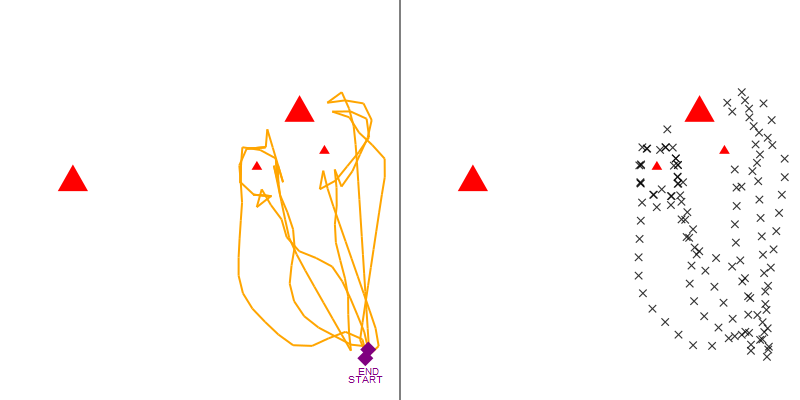

In [9]:
function viz_label(roomnum, tasknum, runno)
    label_key = string(tasknum)*"_"*string(runno)
    x = tasknum <= 40 ? "2" : "4"
    y = string((tasknum-1) % 40 + 1)
    file_name = "memory_"*x*".1."*y*".json"
    room = readdata_get_comm_game_path() * "/python_scripts/visualize/pairs_data/room0000"*roomnum
    dict1 = readdata_get_task_from_room(room, file_name, VERBOSE=false);
    
    playerdata1 = readdata_get_playerdata_from_task(dict1, 2*runno - 1, VERBOSE=false);
    playerdata2 = readdata_get_playerdata_from_task(dict1, 2*runno, VERBOSE=false);
    scene = utils_scene_from_playerdata(playerdata1, VERBOSE=false)
    
    if playerdata1["role"] == "STUDENT"  # Make player1 always teacher
        playerdata1, playerdata2 = playerdata2, playerdata1
    end
    player_trajectory1 = [Point(x, y) for (x, y) in zip(playerdata1["x"], playerdata1["y"])]
    player_trajectory2 = [Point(x, y) for (x, y) in zip(playerdata2["x"], playerdata2["y"])]
    
    trajectory = utils_strip_trajectory(player_trajectory1; epsilon=20)
    println(length(trajectory))
    
    visualize_grid(0:1, 2, 800; separators="gray") do i, frame
        if i == 0
            draw_path(scene, trajectory[1], trajectory[end], trajectory, frame; markersize=8, pathopacity=1)
            # draw_measurements(scene, trajectory, frame; markersize=8)
            draw_scene(scene, frame)
        elseif i == 1 && label_key in keys(labels[roomnum])
            draw_measurements(scene, trajectory[labels[roomnum][label_key]], frame; markersize=8)
            draw_scene(scene, frame)
        end
    end
end
#recheck 9 21 9

roomnum = readdata_all_rooms[9]
roomnum = "76"
tasknum = 21
# tasknum += 1
runno = 9


# labels[roomnum][string(tasknum)*"_"*string(runno)] = [i for i in 14:27]
# labels[roomnum][string(tasknum)*"_"*string(runno)] = [i for i in 24:44]
# labels[roomnum][string(tasknum)*"_"*string(runno)] = [i for i in [15:33;65:76]]
# labels[roomnum][string(tasknum)*"_"*string(runno)] = []
# delete!(labels[roomnum], string(tasknum)*"_"*string(runno))

viz_label(roomnum, tasknum, runno)
# readdata_visualize_memory(roomnum=roomnum, tasknum=tasknum, hide_student=true)
# labels[roomnum]


In [247]:
labels["76"]

Dict{Any, Any} with 33 entries:
  "16_1"  => [15, 16, 17, 18, 19, 20, 21, 22, 23, 24  …  27, 28, 29, 30, 31, 32…
  "19_5"  => Any[]
  "11_2"  => [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2…
  "13_1"  => Any[]
  "15_7"  => Any[]
  "24_1"  => Any[]
  "11_10" => [12, 13, 14, 15, 16, 17, 18, 19, 20, 21  …  33, 34, 35, 36, 37, 38…
  "26_1"  => Any[]
  "28_1"  => Any[]
  "26_10" => [24, 25, 26, 27, 28, 29, 30, 31, 32, 33  …  35, 36, 37, 38, 39, 40…
  "28_3"  => Any[]
  "11_5"  => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  23, 24, 25, 26, 27, 28, 29, 30,…
  "11_13" => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  28, 29, 30, 31, 32, 33, 34, 35,…
  "19_1"  => Any[]
  "14_1"  => Any[]
  "12_1"  => [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
  "28_6"  => Any[]
  "17_4"  => Any[]
  "15_4"  => Any[]
  "16_3"  => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  "10_11" => [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,…
  "26_3"  => Any[]
  "11_16" =

In [551]:

validation_labels = Serialization.deserialize("data/0_labels_7") # LOAD!
for room in keys(validation_labels)
    for data in keys(validation_labels[room])
        if data in keys(labels_loaded[room]) # in training
            delete!(validation_labels[room], data)
        end
    end
end

In [552]:
# PRINTING
for room in keys(validation_labels)
    for data in keys(validation_labels[room])
        if length(validation_labels[room][data]) > 0
            println("P: ", room, ", ", data)
        else
            println("N: ", room, ", ", data)
        end
    end
end

# DOUBLE CHECK
for room in keys(validation_labels)
    for data in keys(validation_labels[room])
        if data in keys(labels_loaded[room]) # in training
            println("SHOULD NOT HAPPEN")
        end
    end
end
